In [1]:
try:
    import warnings
    warnings.filterwarnings('ignore')
    import utils
except Exception as e:
    print(e)
    from tensorflow.keras.applications.vgg16 import preprocess_input
    def preprocess_img(x):
        return preprocess_input(x, mode='tf')
    pass

No module named 'utils'


In [2]:
from keras.preprocessing.image import ImageDataGenerator
from glob import glob
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception
from keras.applications.resnet50 import ResNet50
from keras.models import Model, Sequential, Input
from keras.layers import *
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
import os
import PIL
import time

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

Using TensorFlow backend.


In [3]:
path_data = '../garbage_classify/train_data'
batch_size = 32
img_width = 224
img_height = 224
img_size = 224
random_seed = 201908
path_data_train = '../tmp/data_train/'
path_data_valid = '../tmp/data_valid/'
labels_file = '../tmp/labels_raw.csv'

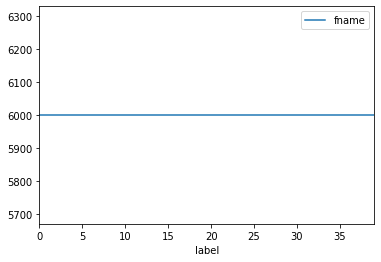

In [4]:
labels_train = pd.read_csv('../tmp/labels_train.csv')
labels_valid = pd.read_csv('../tmp/labels_valid.csv')
n_classess = labels_train.label.unique().shape[0]
n_classess
labels_train.groupby(by='label').count().plot()

In [5]:
labels_train.label = labels_train.label.apply(lambda x: f'{x:02d}')
labels_valid.label = labels_valid.label.apply(lambda x: f'{x:02d}')
# labels_train['label_bin'].values = keras.utils.np_utils.to_categorical(
#     labels_train.label, n_classess)

In [6]:
ig = ImageDataGenerator(preprocessing_function=preprocess_img)

params_g = dict(
    batch_size=batch_size,
    # directory=path_data,
    # class_mode='other',
    x_col='fname',
    y_col='label',
    target_size=(img_width, img_height),
    seed=random_seed)

train_g = ig.flow_from_dataframe(
    labels_train, path_data_train, **params_g)
valid_g = ig.flow_from_dataframe(
    labels_valid, path_data_valid, **params_g)

Found 240000 validated image filenames belonging to 40 classes.
Found 2978 validated image filenames belonging to 40 classes.


In [7]:
base_model = Xception(
    weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# 添加全局平均池化层
x = base_model.output
x = GlobalAveragePooling2D()(x)

# 添加一个全连接层
# x = Dense(512, activation='relu')(x)

x = Dense(128, activation='relu')(x)
# x=Dropout(0.5)(x)

# 添加一个分类器，假设我们有200个类
predictions = Dense(n_classess, activation='softmax')(x)

# 构建我们需要训练的完整模型
model = Model(inputs=base_model.input, outputs=predictions)
# model.summary()
# 首先，我们只训练顶部的几层（随机初始化的层）
# 锁住所有 InceptionV3 的卷积层
for layer in base_model.layers:
    layer.trainable = False

Instructions for updating:
Colocations handled automatically by placer.


In [8]:
# %%
ckpt = ModelCheckpoint(
    '../tmp/ckpt-exp2-'+time.strftime('%Y-%m-%d_%H_%M')+'-Epoch_{epoch:03d}-acc_{acc:.5f}-val_acc_{val_acc:.5f}.h5', save_best_only=True, monitor='val_acc')
estop = EarlyStopping(monitor='val_acc', min_delta=1e-7,
                      verbose=1, patience=20)


In [9]:
model.compile(optimizer=Adam(lr=1e-5), loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit_generator(
    train_g,
    # steps_per_epoch=100,
    steps_per_epoch=train_g.n // batch_size,
    epochs=8,
    callbacks=[ckpt],
    validation_data=valid_g,
    # validation_steps=1,
    validation_steps=valid_g.n // batch_size
)


Instructions for updating:
Use tf.cast instead.
Epoch 1/8
7500/7500 [==============================] - 607s 81ms/step - loss: 2.9089 - acc: 0.3499 - val_loss: 1.3993 - val_acc: 0.6280
Epoch 2/8
7500/7500 [==============================] - 605s 81ms/step - loss: 1.9582 - acc: 0.5434 - val_loss: 1.0418 - val_acc: 0.6999
Epoch 3/8
7500/7500 [==============================] - 606s 81ms/step - loss: 1.6503 - acc: 0.5816 - val_loss: 0.9792 - val_acc: 0.7159
Epoch 4/8
7500/7500 [==============================] - 602s 80ms/step - loss: 1.5075 - acc: 0.6025 - val_loss: 0.9378 - val_acc: 0.7308
Epoch 5/8
7500/7500 [==============================] - 602s 80ms/step - loss: 1.4220 - acc: 0.6167 - val_loss: 0.9473 - val_acc: 0.7298
Epoch 6/8
7500/7500 [==============================] - 605s 81ms/step - loss: 1.3603 - acc: 0.6287 - val_loss: 0.9151 - val_acc: 0.7417
Epoch 7/8
7500/7500 [==============================] - 596s 79ms/step - loss: 1.3156 - acc: 0.6380 - val_loss: 0.9146 - val_acc: 0.7454


In [10]:
# 现在顶层应该训练好了，让我们开始微调 Inception V3 的卷积层。
# 我们会锁住底下的几层，然后训练其余的顶层。

# 让我们看看每一层的名字和层号，看看我们应该锁多少层呢：
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

0 input_1
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d_1
13 block2_pool
14 batch_normalization_1
15 add_1
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_2
23 block3_pool
24 batch_normalization_2
25 add_2
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_3
33 block4_pool
34 batch_normalization_3
35 add_3
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_4
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 block6_sepcon

In [11]:
# 训练block5~14
for layer in model.layers[:35]:
   layer.trainable = False
for layer in model.layers[35:]:
   layer.trainable = True

In [12]:
# 我们需要重新编译模型，才能使上面的修改生效
model.compile(optimizer=Adam(lr=1e-5), loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
model.fit_generator(
    train_g,
    # steps_per_epoch=100,
    steps_per_epoch=train_g.n // batch_size,
    epochs=100,
    callbacks=[ckpt,estop],
    validation_data=valid_g,
    # validation_steps=1,
    validation_steps=valid_g.n // batch_size
)

Epoch 1/100
7500/7500 [==============================] - 1353s 180ms/step - loss: 0.6150 - acc: 0.8134 - val_loss: 0.5211 - val_acc: 0.8435
Epoch 2/100
7500/7500 [==============================] - 1327s 177ms/step - loss: 0.2196 - acc: 0.9357 - val_loss: 0.4930 - val_acc: 0.8557
Epoch 3/100
7500/7500 [==============================] - 1328s 177ms/step - loss: 0.0866 - acc: 0.9785 - val_loss: 0.4862 - val_acc: 0.8618
Epoch 4/100
7500/7500 [==============================] - 1329s 177ms/step - loss: 0.0373 - acc: 0.9920 - val_loss: 0.5087 - val_acc: 0.8642
Epoch 5/100
7500/7500 [==============================] - 1329s 177ms/step - loss: 0.0181 - acc: 0.9967 - val_loss: 0.5292 - val_acc: 0.8649
Epoch 6/100
7500/7500 [==============================] - 1336s 178ms/step - loss: 0.0108 - acc: 0.9981 - val_loss: 0.5509 - val_acc: 0.8673
Epoch 7/100
7500/7500 [==============================] - 1330s 177ms/step - loss: 0.0073 - acc: 0.9987 - val_loss: 0.5522 - val_acc: 0.8714
Epoch 8/100
7500/750